In [1]:
from Image_generation.image1D import SourceImage1D
from Image_generation.image1D import CustomUnlabeledDataset
from diffml.systems import ImagingSystem
import diffml
import torch
from diffml.utils import plot_field

# Define lens

In [2]:
dim_lens = 6000 # Number of pixels in the lens
dim_in = 1000  # Number of pixels in the input plane
dim_out = 1000  # Number of pixels in the output plane
pixel_size = 1e-6  # meters
wavelength = 700e-9
layer_distances = [1, 1]  # meters (input plane to lens, lens to output plane)
samples_per_pixel = 1
propagation_algorithm = "riemann"
device = "cpu"

lens_size = dim_lens * pixel_size  # meters
focal_length = ImagingSystem.calculate_focal_length(layer_distances[0], layer_distances[1])
network_dimensions = [dim_in, dim_lens, dim_out]
print(f"lens size: {lens_size} m \nfocal length: {focal_length} m")

imaging_system = ImagingSystem(
    network_dimensions, pixel_size, wavelength, layer_distances, samples_per_pixel, propagation_algorithm, focal_length
).to(device)

# Print relavent physical properties.
lens_radius = dim_lens*pixel_size/2
NA = lens_radius/layer_distances[0]
unit = wavelength/(2*NA)
print(f"unit= {unit}, \nRayleigh limit = {1.22*unit}, \nsigma = {0.42*unit}, \nNA = {NA}")

image_cls = SourceImage1D(dim_in, img_size=dim_in*pixel_size)

lens size: 0.006 m 
focal length: 0.5 m
unit= 0.00011666666666666667, 
Rayleigh limit = 0.00014233333333333334, 
sigma = 4.9e-05, 
NA = 0.003


# Test one double slit

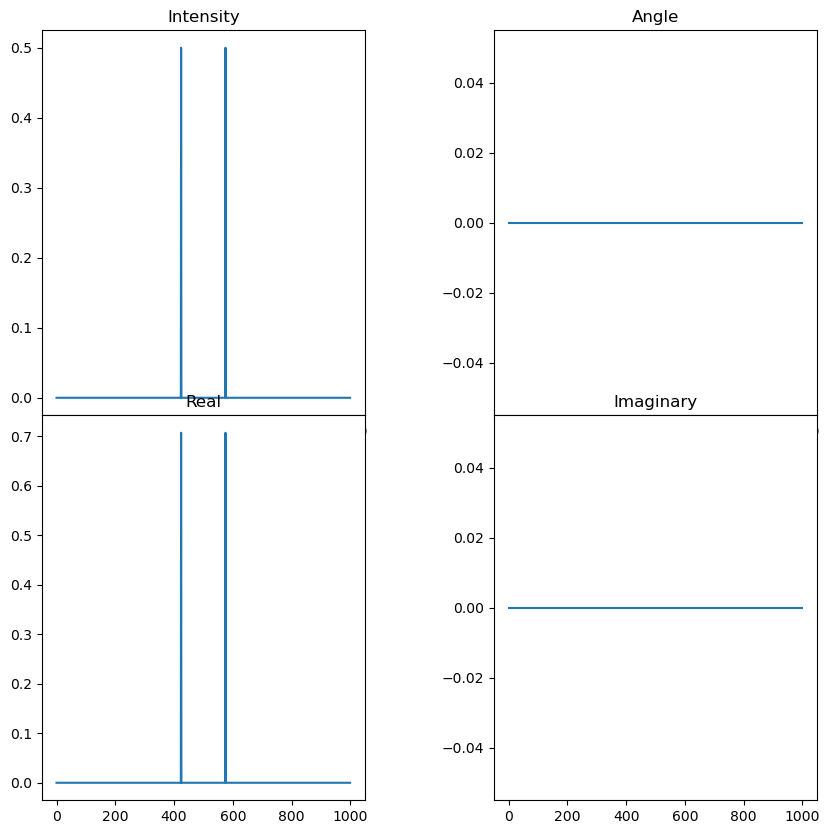

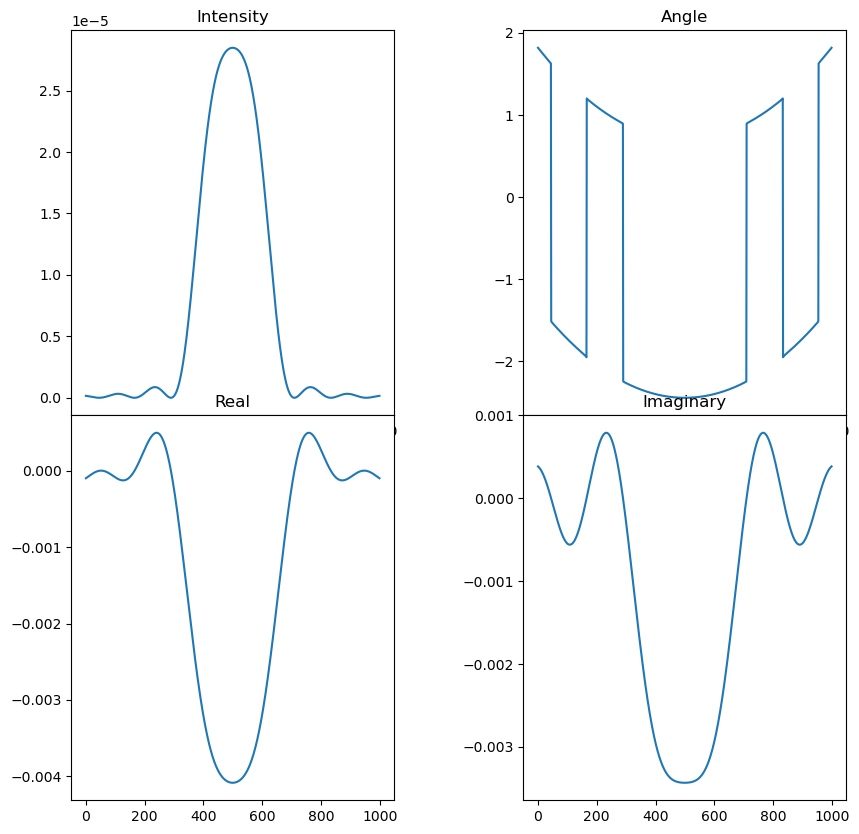

In [3]:
image_cls = SourceImage1D(dim_in, img_size=dim_in*pixel_size)

double_source = torch.tensor(image_cls.double_slit(1.3*unit), dtype=torch.complex64)

double_img = imaging_system(double_source)

plot_field(double_source)
plot_field(double_img)

In [ ]:
def add_guassian(img, num_photons_per_pxl, pixel_size):
    phases = torch.rand(img.size())
    noise_amplitude = torch.zeors_like(img)
    noise_amplitude = torch.normal(noise_amplitude, torch.sqrt(num_photons_per_pxl))
    noise =  noise_amplitude*torch.exp(1j*phases)
    return img+noise

def normalise_img_int(img, pixel_size, intensity):
    '''
    
    Args:
        img: 
        pixel_size: 
        intensity: the target intensity

    Returns: The img whose total intensity is 'intensity'

    '''
    
    original_intensity = torch.sum(img.abs().pow(2), dim=1) * pixel_size
    normalised_img = intensity**0.5 * img / original_intensity**0.5
    return normalised_img